In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time
import configparser


save_path = '../Scrittek/figures/'
#I/O 
spectra_filename = 'NO_ARS_13_02'
now_path            =   '../BRILLOUIN/TDP43/' +spectra_filename +'/'

inputs = configparser.ConfigParser()

with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)


############
#I/O 

VIPA_filename       =   inputs['I/O']['VIPA_filename']
log_file            =   'log_'+spectra_filename
transpose           =   inputs.getboolean('I/O', 'transpose')

#operatives
to_add              =   eval(inputs['Operatives']['to_add'])
exclude_delta       =   inputs.getboolean('Operatives', 'exclude_delta')

syg_kwargs          =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs')}
syg_kwargs_VIPA     =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_VIPA')}
syg_kwargs_brill    =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_brill')}
VIPA_treshold       =  inputs.getfloat('Operatives','VIPA_treshold')
sat_height          =  inputs.getfloat('Operatives','sat_height')
sat_width           =  inputs.getfloat('Operatives','sat_width')
almost_treshold     =  inputs.getfloat('Operatives','almost_treshold')
pre_cut             =  inputs.getboolean('Operatives','pre_cut')
cut                 =  inputs.getboolean('Operatives','cut')
mean_dist_01        =  inputs.getfloat('Operatives','mean_dist_01')
mean_dist_23        =  inputs.getfloat('Operatives','mean_dist_23')
#markov_fit

recover_markov      = inputs.getboolean('Markov', 'recover_markov')
p0_normal           = np.array(eval(inputs['Markov']['p0_normal']))
p0_brillouin        = np.array(eval(inputs['Markov']['p0_brillouin']))
p0_almost           = np.array(eval(inputs['Markov']['p0_almost']))

rules_markov_bounds =   eval(inputs['Markov']['rules_markov_bounds'])
#tot fit
skip_tot            =  inputs.getboolean('Tot', 'skip_tot')
rules_tot_bounds    =   eval(inputs['Tot']['rules_tot_bounds'])


############


cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark_nodelta  = ('Co', 'Omega', 'Gamma', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_real_nodelta =  ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'shift', 'offset')

cols_gauss  = ( 'A', 'mu', 'sigma')
print('OK, variabili operative:\nexculde delta = {}\nbounds markov = {}'.format(exclude_delta, str(rules_markov_bounds)))

OK, variabili operative:
exculde delta = True
bounds markov = ('positive', 0.2, 'positive', [-2, 2], 'positive', 'positive', 0.2, 0.01, 0.001, 'inf', [-2, 2])


ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


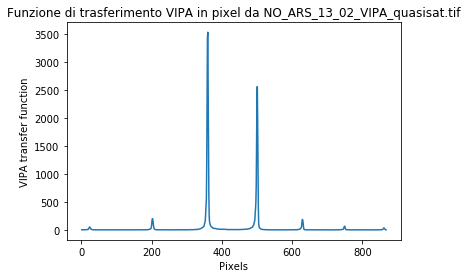

Text(0.5, 1.0, '(3, 37)')

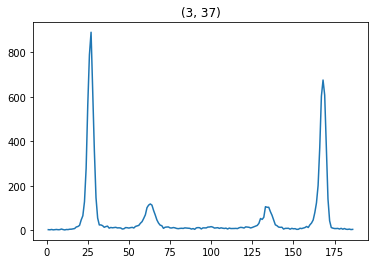

In [28]:
#0) importo dati e inizializzo oggetti
i   =   3
j   =   37
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3', transpose = transpose)[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Lo spettro è normal
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(3, 37)')

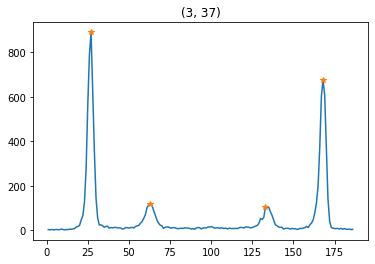

In [29]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    if (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][1]]) & (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][3]]):
        nature    = 'brillouin_highest_dx'
    elif (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][2]]) & (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][0]]):
        nature    = 'brillouin_highest_sx'
    else:
        raise ValueError ('Non ho riconosciuto lo spettro\n')

elif (Data.n_peaks == 3) :
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

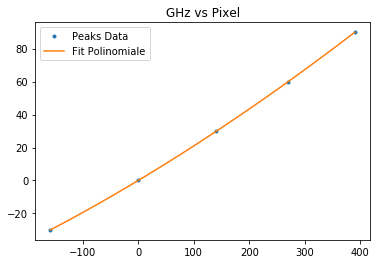

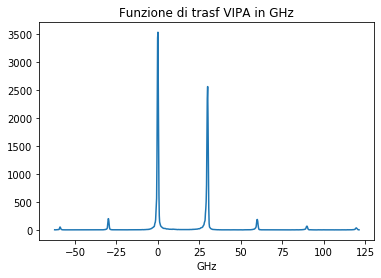

In [30]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)


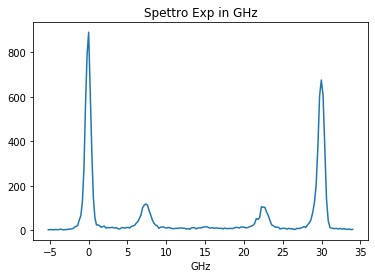

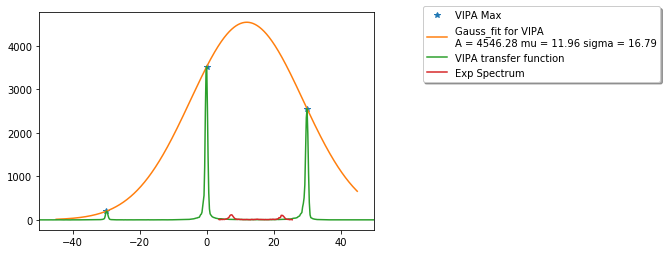

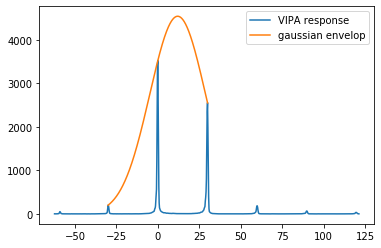

In [31]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive
from Alessandria import gaussian
Data.Align_Spectrum()
Data.Spectrum_Pix2GHz(fig = True)
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = cut, mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23, verbose = True)
Data.Fit_VIPA_Gaussian(fig = True)
plt.figure()
plot(Data.x_VIPA_freq, Data.y_VIPA, label = 'VIPA response')
x = np.linspace(-30,30,1000)
plt.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelop')
plt.legend()

Cost before fitting = 58184.4672216608
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8184e+04                                    1.22e+05    
       1              2         1.3922e+04      4.43e+04       3.96e+02       3.12e+04    
       2              3         3.1491e+03      1.08e+04       2.48e+02       2.20e+04    
       3              4         7.9359e+02      2.36e+03       1.45e+02       5.73e+03    
       4              5         2.7099e+02      5.23e+02       9.02e+01       1.93e+03    
       5              6         1.3263e+02      1.38e+02       1.19e+03       1.17e+03    
       6              7         7.1172e+01      6.15e+01       6.18e+02       3.92e+01    
       7              8         6.1587e+01      9.58e+00       3.95e+02       1.26e+01    
       8              9         5.9609e+01      1.98e+00       1.60e+03       4.28e+00    
       9             10         5.9082e+01      5.2

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.013278,7.391370,0.163925,0.116565,0.035403,0.012834,3.646162e+03,12.081895,16.807592,0.052000,2.000000
StdErrs,0.016804,0.021761,0.015372,0.021608,0.020709,0.006413,6.943636e+09,11.249884,35.946356,0.020408,0.676719
Initials,0.010000,7.443440,0.100000,0.000000,0.100000,1.000000,4.546282e+03,11.962272,16.790802,0.000000,0.000000


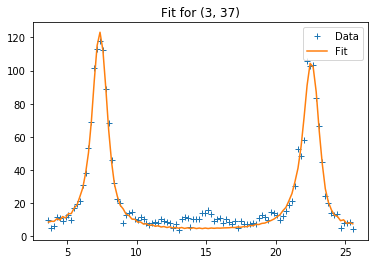

In [26]:
#3) fit markoviano
exclude_delta = False
if (exclude_delta) & (nature != 'almost_height'):
    print('porcodio')
    columns = cols_mark_nodelta
    Data.Get_Fit_Bounds(rules_markov_bounds[0:3]+rules_markov_bounds[6:], columns)
else:
    columns = cols_mark
    Data.Get_Fit_Bounds(rules_markov_bounds, columns)

Data.Get_VIPA_for_fit(mode = 'interpolate', interpolation_density = 500)

p0s = [Data.p0[list(columns)].values[0]]#, p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, columns)
Data.Get_cost_markov(Data.p0[list(columns)].values[0], columns = columns)
print('Cost before fitting = {}'.format(Data.cost_markov))


_= Data.Non_Linear_Least_Squares_Markov(columns,  bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, fig = True, zoom = False, method = 'trf',)
#_= Data.Non_Linear_Least_Squares_Markov(columns, verbose = 2, max_nfev = 200, fig = True, zoom = False, method = 'lm')
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = columns)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [27]:
Data.Markov_Fit_Params.values[0]

array([1.32778004e-02, 7.39136968e+00, 1.63924613e-01, 1.16564658e-01,
       3.54028085e-02, 1.28336321e-02, 3.64616242e+03, 1.20818949e+01,
       1.68075924e+01, 5.19998078e-02, 2.00000000e+00])

The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 3.7019e+01, final cost 3.4842e+01, first-order optimality 3.90e+01.
s impiegati a fare il fit totale  4.719843202 



,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.008609,7.585570,0.175071,0.513855,0.695466,0.222446,0.057743,0.087347,0.018890,4.338747
StdErrs,0.031576,28.038479,0.071301,130.982876,76.573470,0.014185,0.028628,0.078068,0.025940,2.734384
Initials,0.008406,7.765440,0.186585,0.186585,1.000000,0.222547,0.056847,0.088001,0.018283,4.739732


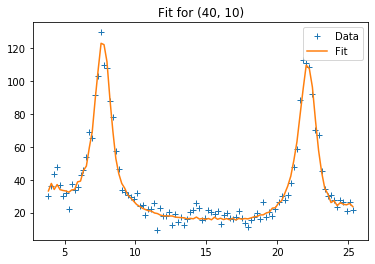

In [7]:
#4) fit totale
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]

if (exclude_delta) & (nature != 'almost_height'):
    print('porcodio')
    columns = cols_real_nodelta
    rules_tot_bounds = rules_tot_bounds[0:5]+rules_tot_bounds[8:]
else:
    columns = cols_real


Data.Initials_Parameters_from_Markov()
Data.Get_Fit_Bounds(rules_tot_bounds, columns)

#_ = Data.Non_Linear_Least_Squares(p_gauss, columns, bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50, method = 'trf')
_ = Data.Non_Linear_Least_Squares(p_gauss, columns, verbose = 2, fig = True, max_nfev = 50, method = 'lm')
Data.Tot_Fit_Params